# Sprint 12: Supervised learning

#### Imports

In [1]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
from sklearn import preprocessing
from sklearn.model_selection import train_test_split
import warnings
warnings.filterwarnings('ignore')
from sklearn.linear_model import LinearRegression
from sklearn.ensemble import RandomForestRegressor
from sklearn.linear_model import LassoCV
from sklearn.metrics import mean_absolute_error,mean_squared_error, r2_score

In [2]:
df = pd.read_csv("DelayedFlights.csv")
df.head(2)

,Unnamed: 0,Year,Month,DayofMonth,DayOfWeek,DepTime,CRSDepTime,ArrTime,CRSArrTime,UniqueCarrier,...,TaxiIn,TaxiOut,Cancelled,CancellationCode,Diverted,CarrierDelay,WeatherDelay,NASDelay,SecurityDelay,LateAircraftDelay
0,0,2008,1,3,4,2003.0,1955,2211.0,2225,WN,...,4.0,8.0,0,N,0,NaN,NaN,NaN,NaN,NaN
1,1,2008,1,3,4,754.0,735,1002.0,1000,WN,...,5.0,10.0,0,N,0,NaN,NaN,NaN,NaN,NaN


## Level 1

### Exercise 1

##### Create 3 different models of regression to predict arrival delays from dataset of airlines. How to predict arrival delay? Which regression models we can use?

I will create model to predict arrival delay for one airline and one destination.
- First select destination to New York - code JFK
- Second select the most frequent airline JetBlue Airways - code B6

In [3]:
a = df.loc[df['Dest'] == 'JFK']
a['UniqueCarrier'].describe()

count     35506
unique       11
top          B6
freq      15122
Name: UniqueCarrier, dtype: object

In [4]:
a['Dest'].unique()

array(['JFK'], dtype=object)

In [5]:
b = a.loc[df['UniqueCarrier'] == 'B6']
b['UniqueCarrier'].unique()

array(['B6'], dtype=object)

In [6]:
df_flights = b[['Cancelled','ArrDelay','DepDelay','Distance','CarrierDelay',
       'WeatherDelay', 'NASDelay', 'SecurityDelay', 'LateAircraftDelay','Month', 'DayofMonth']]
df_flights.head(3)

,Cancelled,ArrDelay,DepDelay,Distance,CarrierDelay,WeatherDelay,NASDelay,SecurityDelay,LateAircraftDelay,Month,DayofMonth
168228,0,-19.0,9.0,1522,NaN,NaN,NaN,NaN,NaN,1,1
168229,0,-6.0,13.0,766,NaN,NaN,NaN,NaN,NaN,1,1
168230,0,19.0,24.0,766,0.0,0.0,0.0,0.0,19.0,1,1


In [7]:
#deleting rows with cancelled flights
df_flights = df_flights.loc[df_flights['Cancelled'] == 0]
df_flights.drop('Cancelled',axis=1, inplace=True)
df_flights.reset_index()
df_flights.tail(3)

,ArrDelay,DepDelay,Distance,CarrierDelay,WeatherDelay,NASDelay,SecurityDelay,LateAircraftDelay,Month,DayofMonth
1921774,199.0,172.0,1005,0.0,0.0,28.0,0.0,171.0,12,31
1921775,71.0,86.0,1005,0.0,0.0,1.0,0.0,70.0,12,31
1921776,31.0,42.0,1005,0.0,0.0,18.0,0.0,13.0,12,31


In [8]:
#Do I have complete values dataset? how many NaN values I have?
a = df_flights['ArrDelay'].isnull().sum()
b = df_flights['DepDelay'].isnull().sum()
c = df_flights['Distance'].isnull().sum()
d = df_flights['CarrierDelay'].isnull().sum()
e = df_flights['WeatherDelay'].isnull().sum()
f = df_flights['NASDelay'].isnull().sum()
g = df_flights['SecurityDelay'].isnull().sum()
h = df_flights['LateAircraftDelay'].isnull().sum()
i = df_flights['Month'].isnull().sum()
j = df_flights['DayofMonth'].isnull().sum()
print(a, b, c, d, e, f, g, h, i, j)

121 0 0 4372 4372 4372 4372 4372 0 0


In [9]:
#Replace NaN values with 0 and check new df
df_flights['ArrDelay'] = df_flights['ArrDelay'].replace(np.nan, 0)
df_flights['CarrierDelay'] = df_flights['CarrierDelay'].replace(np.nan, 0)
df_flights['WeatherDelay'] = df_flights['WeatherDelay'].replace(np.nan, 0)
df_flights['NASDelay'] = df_flights['NASDelay'].replace(np.nan, 0)
df_flights['SecurityDelay'] = df_flights['SecurityDelay'].replace(np.nan, 0)
df_flights['LateAircraftDelay'] = df_flights['LateAircraftDelay'].replace(np.nan, 0)
df_flights.isnull().values.any()

False

##### What is the relationship between arrival delay, month and day of month for flights with destination New York?

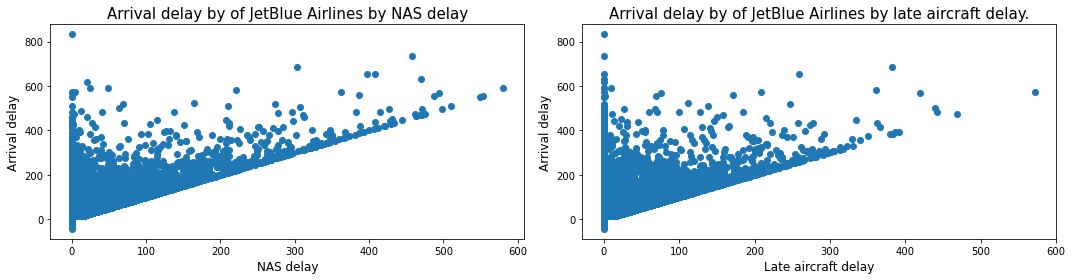

In [10]:
fig,axes = plt.subplots(nrows=1,ncols=2,figsize=(15,4))

axes[0].plot(df_flights['NASDelay'],df_flights['ArrDelay'],'o')
axes[0].set_xlabel("NAS delay",fontsize=12)
axes[0].set_ylabel("Arrival delay",fontsize=12)
axes[0].set_title("Arrival delay by of JetBlue Airlines by NAS delay",fontsize=15)

axes[1].plot(df_flights['LateAircraftDelay'],df_flights['ArrDelay'],'o')
axes[1].set_xlabel("Late aircraft delay",fontsize=12)
axes[1].set_ylabel("Arrival delay",fontsize=12)
axes[1].set_title("Arrival delay by of JetBlue Airlines by late aircraft delay.",fontsize=15)

plt.tight_layout();

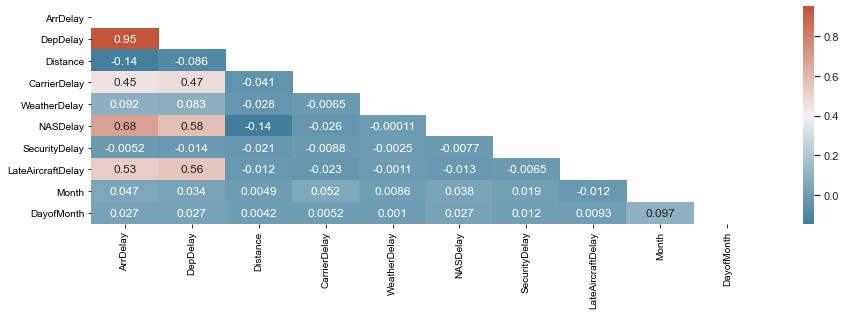

In [11]:
#Correlation matrix
fig,ax = plt.subplots(figsize=(15,4))
corr = df_flights.corr()
sns.set_theme(style="white")
cmap = sns.diverging_palette(230, 20, as_cmap=True)

matrix = np.triu(corr)
sns.heatmap(corr, annot=True, mask=matrix, cmap=cmap)
plt.show()

Interpretation:
- Correlation between ArrDelay and DepDelay 
- ArrDelay and NASDelay
- ArrDelay and LateAircraftDelay
- ArrDelay and Carrier delay

#### Train and test samples

In [12]:
#random sample
df_flights_sample = df_flights.sample(n = 1000)
df_flights_sample.head(5)

,ArrDelay,DepDelay,Distance,CarrierDelay,WeatherDelay,NASDelay,SecurityDelay,LateAircraftDelay,Month,DayofMonth
1063615,1.0,20.0,1028,0.0,0.0,0.0,0.0,0.0,6,19
1245705,120.0,64.0,541,0.0,0.0,73.0,0.0,47.0,7,17
1062867,42.0,57.0,2454,6.0,0.0,0.0,0.0,36.0,6,15
1244884,46.0,52.0,426,4.0,0.0,0.0,0.0,42.0,7,11
1245528,18.0,30.0,1028,0.0,0.0,18.0,0.0,0.0,7,15


In [13]:
X = df_flights_sample.drop('ArrDelay',axis=1)
y = df_flights_sample['ArrDelay']
#Train 70%, test 30%, test_size is the percentage and random_state is for initilizing random number generator
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.3, random_state=42)

In [14]:
print(X_train.shape,y_train.shape, X_test.shape, y_test.shape)

(700, 9) (700,) (300, 9) (300,)


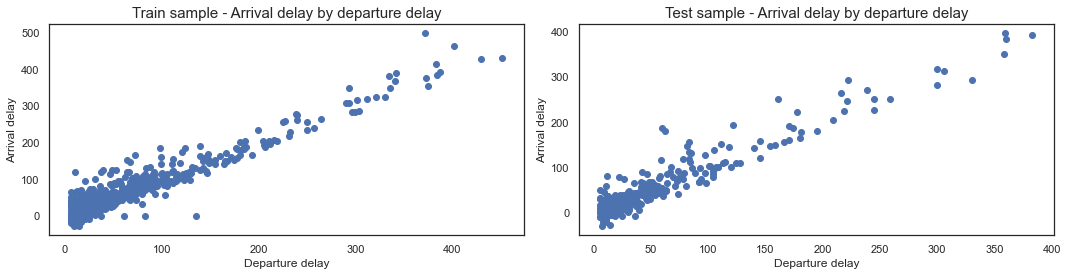

In [15]:
#display the train and test set
fig,axes = plt.subplots(nrows=1,ncols=2,figsize=(15,4))

axes[0].plot(X_train['DepDelay'],y_train,'o')
axes[0].set_title("Train sample - Arrival delay by departure delay",fontsize=15)
axes[0].set_xlabel("Departure delay",fontsize=12)
axes[0].set_ylabel("Arrival delay",fontsize=12)

axes[1].plot(X_test['DepDelay'],y_test,'o')
axes[1].set_title("Test sample - Arrival delay by departure delay",fontsize=15)
axes[1].set_xlabel("Departure delay",fontsize=12)
axes[1].set_ylabel("Arrival delay",fontsize=12)

plt.tight_layout();

#### Linear regression

Info: https://scikit-learn.org/stable/modules/generated/sklearn.linear_model.LinearRegression.html

In [16]:
model1 = LinearRegression()
model1.fit(X_train,y_train)
test_predictions1 = model1.predict(X_test)
print(len(test_predictions1))

300


In [17]:
y = X_test
f = test_predictions1
r_sq = model1.score(y,f)
print('r2 score model is', r_sq)

r2 score model is 1.0


Interpretation:
- Best possible score is 1.0
- Baseline is 0
- Worse cases can have score negative

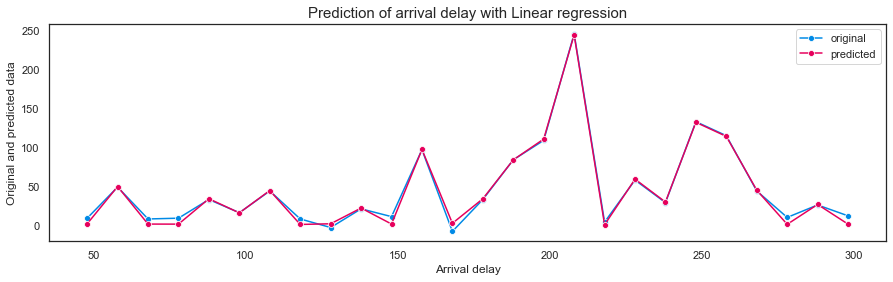

In [18]:
#compare values from test and predict
y1 = y_test.reset_index(drop=True)
y2 = pd.Series(model1.predict(X_test))

#for simple visualization let's take sistematic sample
step_num = 10
def randomNum():
    num = np.random.randint(1, 50)
    return num
num = randomNum()

simple_df1 = y1[num:len(y1):step_num]
simple_df2 = y2[num:len(y2):step_num]

plt.figure(figsize =(15, 4))

sns.lineplot(data=simple_df1, color='#008ae6',label='original', marker='o')
sns.lineplot(data=simple_df2, color='#e6005c',label='predicted', marker='o')
plt.title("Prediction of arrival delay with Linear regression",fontsize=15)
plt.xlabel("Arrival delay",fontsize=12)
plt.ylabel("Original and predicted data",fontsize=12)

plt.show()

#### Random forest regression

Info: https://scikit-learn.org/stable/modules/generated/sklearn.ensemble.RandomForestRegressor.html

In [102]:
#baseline prediction error
feature_list = list(X_test.columns)
baseline_preds = X_test['DepDelay']

baseline_errors = abs(baseline_preds - y_test)
print('Average baseline error: ', round(np.mean(baseline_errors), 2),'minutes.')

Average baseline error:  16.04 minutes.


In [103]:
model2 = RandomForestRegressor(n_estimators = 10, max_depth=10, random_state = 42)
model2.fit(X_train, y_train);

In [104]:
test_predictions2 = model2.predict(X_test)
errors = abs(test_predictions2 - y_test)
print('Mean Absolute Error:', round(np.mean(errors), 2), 'minutes.')

Mean Absolute Error: 9.42 minutes.


Interpretation:
- The model is quite good based on the calculated error

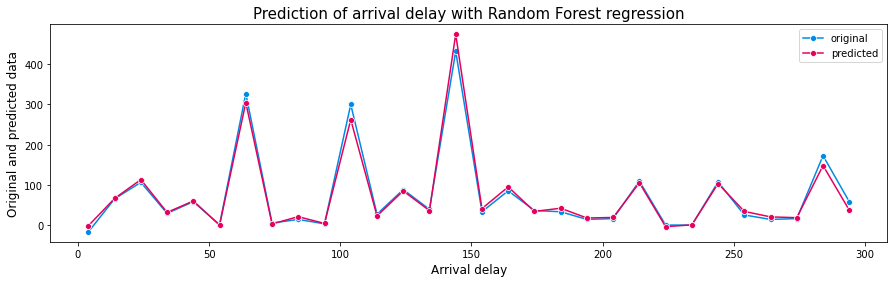

In [105]:
#compare values from test and predict
y1 = y_test.reset_index(drop=True)
y2 = pd.Series(model2.predict(X_test))

#for simple visualization let's take sistematic sample
step_num = 10
def randomNum():
    num = np.random.randint(1, 50)
    return num
num = randomNum()

simple_df1 = y1[num:len(y1):step_num]
simple_df2 = y2[num:len(y2):step_num]

plt.figure(figsize =(15, 4))

sns.lineplot(data=simple_df1, color='#008ae6',label='original', marker='o')
sns.lineplot(data=simple_df2, color='#e6005c',label='predicted', marker='o')
plt.title("Prediction of arrival delay with Random Forest regression",fontsize=15)
plt.xlabel("Arrival delay",fontsize=12)
plt.ylabel("Original and predicted data",fontsize=12)

plt.show()

#### Lasso regression

Info: https://scikit-learn.org/stable/modules/generated/sklearn.linear_model.LassoCV.html

In [106]:
model3 = LassoCV(n_alphas = 10, fit_intercept=False, max_iter=10,random_state = 42)
model3.fit(X_train, y_train)

LassoCV(fit_intercept=False, max_iter=10, n_alphas=10, random_state=42)

In [107]:
test_predictions3 = model3.predict(X_test)
errors = abs(test_predictions3 - y_test)
print('Mean Absolute Error:', round(np.mean(errors), 2), 'minutes.')

Mean Absolute Error: 11.97 minutes.


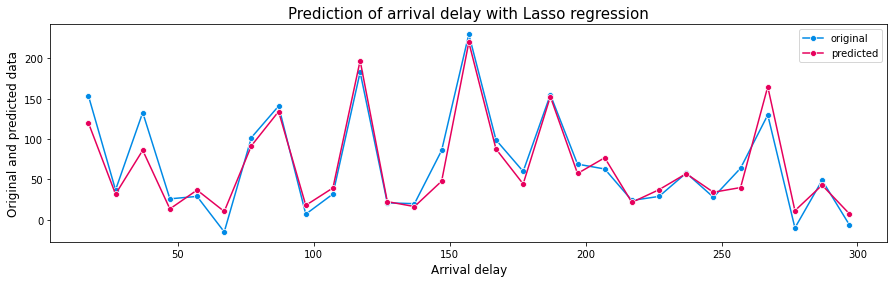

In [108]:
#compare values from test and predict
y1 = y_test.reset_index(drop=True)
y2 = pd.Series(model3.predict(X_test))

#for simple visualization let's take sistematic sample
step_num = 10
def randomNum():
    num = np.random.randint(1, 50)
    return num
num = randomNum()

simple_df1 = y1[num:len(y1):step_num]
simple_df2 = y2[num:len(y2):step_num]

plt.figure(figsize =(15, 4))

sns.lineplot(data=simple_df1, color='#008ae6',label='original', marker='o')
sns.lineplot(data=simple_df2, color='#e6005c',label='predicted', marker='o')
plt.title("Prediction of arrival delay with Lasso regression",fontsize=15)
plt.xlabel("Arrival delay",fontsize=12)
plt.ylabel("Original and predicted data",fontsize=12)

plt.show()

#### Polynomial regression

Info: https://towardsdatascience.com/polynomial-regression-bbe8b9d97491

In [26]:
#fitting Polynomial Regression to the dataset
from sklearn.preprocessing import PolynomialFeatures
polynomial_features = PolynomialFeatures(degree=2)
X_poly = polynomial_features.fit_transform(X_train)

polynomial_features.fit(X_poly, y_train)
model4 = LinearRegression()
model4.fit(X_poly, y_train)

LinearRegression()

In [38]:
test_predictions4 = model4.predict(X_poly)
score4 = model4.score(X_poly,y_train)
print(score4)

0.9968455897223958


#### Decision Tree regression

Info: https://www.geeksforgeeks.org/python-decision-tree-regression-using-sklearn/

In [47]:
#fitting Decision Tree Regression to the dataset
from sklearn.tree import DecisionTreeRegressor
model5 = DecisionTreeRegressor(random_state = 0) 
model5.fit(X_train, y_train)

DecisionTreeRegressor(random_state=0)

In [83]:
test_predictions5 = model5.predict(X_train)
score5 = model5.score(X_train,y_train)
size5 = test_predictions5.size
print(score5,size5)

1.0 700


#### Neural networks

Info: https://thinkingneuron.com/using-artificial-neural-networks-for-regression-in-python/

In [72]:
import tensorflow as tf

input_size=2
output_size=1
model6 = tf.keras.Sequential([tf.keras.layers.Dense(output_size)])
model6.compile(loss='mean_squared_error', optimizer='adam')
model6.fit(X_train, y_train, batch_size = 50, epochs = 30, verbose=1)

Epoch 1/30
14/14 [==============================] - 0s 756us/step - loss: 545288.5000
Epoch 2/30
14/14 [==============================] - 0s 686us/step - loss: 516053.9062
Epoch 3/30
14/14 [==============================] - 0s 817us/step - loss: 487622.0938
Epoch 4/30
14/14 [==============================] - 0s 696us/step - loss: 460519.7812
Epoch 5/30
14/14 [==============================] - 0s 862us/step - loss: 434481.8438
Epoch 6/30
14/14 [==============================] - 0s 791us/step - loss: 410181.8438
Epoch 7/30
14/14 [==============================] - 0s 892us/step - loss: 386268.4375
Epoch 8/30
14/14 [==============================] - 0s 682us/step - loss: 363945.0312
Epoch 9/30
14/14 [==============================] - 0s 704us/step - loss: 342989.5000
Epoch 10/30
14/14 [==============================] - 0s 918us/step - loss: 322785.0000
Epoch 11/30
14/14 [==============================] - 0s 691us/step - loss: 303471.9688
Epoch 12/30
14/14 [==============================] -

In [76]:
test_predictions6 = model6.predict(X_train)
test_predictions6[:10]

array([[ 27.885487],
       [ 12.337156],
       [332.9933  ],
       [208.65257 ],
       [144.39182 ],
       [ 33.379925],
       [ 28.65989 ],
       [358.4983  ],
       [-40.485878],
       [230.48866 ]], dtype=float32)

In [81]:
test_predictions6.size

700

In [85]:
print(model6.evaluate(X_train, y_train))

22/22 [==============================] - 0s 601us/step - loss: 86696.6797
86696.6796875


### Exercise 2

##### Compare MSE and R2 of these 3 models - Linear Regression, Random forest and Lasso

In [109]:
MSE1 = round(mean_squared_error(y_test,test_predictions1),4)
R2_1 = round(r2_score(y_test,test_predictions1),4)

MSE2 = round(mean_squared_error(y_test,test_predictions2),4)
R2_2 = round(r2_score(y_test,test_predictions2),4)

MSE3 = round(mean_squared_error(y_test,test_predictions3),4)
R2_3 = round(r2_score(y_test,test_predictions3),4)

print('Mean square error of linear regression is:',MSE1, 'and R2 score is:', R2_1)
print('Mean square error of random forest regression is:',MSE2, 'and R2 score is:', R2_2)
print('Mean square error of lasso regression is:',MSE3, 'and R2 score is:', R2_3)

Mean square error of linear regression is: 19.2947 and R2 score is: 0.9973
Mean square error of random forest regression is: 300.4741 and R2 score is: 0.9579
Mean square error of lasso regression is: 323.7244 and R2 score is: 0.9546


Interpretation:
- Linear regression and Lasso regression algorithms would be a good option for machine learning

### Exercise 3

##### Train the models with different parameters.

#### Linear regression

In [110]:
#changing parameters of Linear Regression
#model = LinearRegression() original
model1_mod = LinearRegression(fit_intercept = False, normalize=True, positive=True)
#fit_intercept default True, normalize default False

In [111]:
#new scores
model1_mod.fit(X_train, y_train)
score_test = model1_mod.score(X_test, y_test)
score_train = model1_mod.score(X_train, y_train)
score_test,score_train

(0.9972923767549035, 0.9968284230743574)

In [112]:
#old scores from the initial model
score_test = model1.score(X_test, y_test)
score_train = model1.score(X_train, y_train)
score_test,score_train

(0.9972953459661921, 0.9968310008989788)

In [113]:
test_predictions1_mod = model1_mod.predict(X_test)
df1_mod=pd.DataFrame({'Actual':y_test, 'Predicted':test_predictions1_mod})
df1_mod.head()

,Actual,Predicted
358576,22.0,22.306554
1061737,94.0,93.403672
556249,42.0,42.503503
169113,0.0,0.356184
1722050,-16.0,1.207466


Interpretation: Both models are very accurate and the change of parameters did not affect the result significantly. We could use Linear Regression without changing parameters for this particular model.

#### Random forest regression

In [114]:
#changing parameters of Random forest regression
#rf = RandomForestRegressor()original
model2_mod = RandomForestRegressor(n_estimators = 100, max_depth=30, random_state = 42)

In [115]:
#new scores
model2_mod.fit(X_train, y_train)
score_test = model2_mod.score(X_test, y_test)
score_train = model2_mod.score(X_train, y_train)
score_test,score_train

(0.9639540122555542, 0.9926243854895977)

In [116]:
#old scores from the initial model
score_test = model2.score(X_test, y_test)
score_train = model2.score(X_train, y_train)
score_test,score_train

(0.9578806701792072, 0.9900455722501987)

In [117]:
test_predictions2_mod = model2_mod.predict(X_test)
df2_mod=pd.DataFrame({'Actual':y_test, 'Predicted':test_predictions1_mod})
df2_mod.head()

,Actual,Predicted
358576,22.0,22.306554
1061737,94.0,93.403672
556249,42.0,42.503503
169113,0.0,0.356184
1722050,-16.0,1.207466


Interpretation: Both models are very accurate and the change of estimators improved the performance. For some models we might use less estimators because of the computational speed is better and the result is still very good.

#### Lasso regression

In [118]:
#changing parameters of Lasso regression
#default n_alphas=100, fit_intercept=True, max_iter=1000
model3_mod = LassoCV(n_alphas = 100, fit_intercept=True, max_iter=100,random_state = 42)
model3_mod.fit(X_train, y_train)

LassoCV(max_iter=100, random_state=42)

In [119]:
#new scores
model3_mod.fit(X_train, y_train)
score_test = model3_mod.score(X_test, y_test)
score_train = model3_mod.score(X_train, y_train)
score_test,score_train

(0.9945681028202221, 0.9964743443594616)

In [120]:
#old scores from the initial model
score_test = model3.score(X_test, y_test)
score_train = model3.score(X_train, y_train)
score_test,score_train

(0.9546215292085382, 0.9583348320165543)

Interpretation: The change of parameters significantly improved the model, it's good to calculate interconcept for the model and has 100 alphas along regularization path.

### Exercise 4

##### Compare the performance. 

In [149]:
#linear regression
score1 = model1_mod.score(X_train,y_train)

#random forest
score2 = model2_mod.score(X_train,y_train)

#lasso
score3 = model3_mod.score(X_train,y_train)
print(score1, score2, score3)

0.9960684141925801 0.9562628584028351 0.9955228406023293


In [150]:
a = y_test.reset_index(drop=True)#original values
b = pd.Series(model1_mod.predict(X_test))
c = pd.Series(model2_mod.predict(X_test))
d = pd.Series(model3_mod.predict(X_test))
df_perf1 = pd.DataFrame({'Actual':a, 'Predicted LinReg':b, 'Predicted RandFor':c, 'Predicted Lasso':d})
df_perf1.head(10)

,Actual,Predicted LinReg,Predicted RandFor,Predicted Lasso
0,259.0,259.298010,253.18,260.331152
1,16.0,16.798206,16.70,16.735695
2,-8.0,0.820690,-1.97,1.062348
3,24.0,24.007075,21.73,24.320156
4,121.0,121.775640,93.03,120.800053
5,28.0,28.365805,30.76,27.823005
6,70.0,70.228674,71.29,69.902088
7,71.0,71.035376,68.59,71.199632
8,21.0,21.332285,20.71,21.847375
9,26.0,26.176725,25.91,26.582046


Interpretation: 
- The Linear Regression algorithm based on random sample is very accurate.
- Also Lasso Regression model has very high score and would be good for developing a machine learning model.

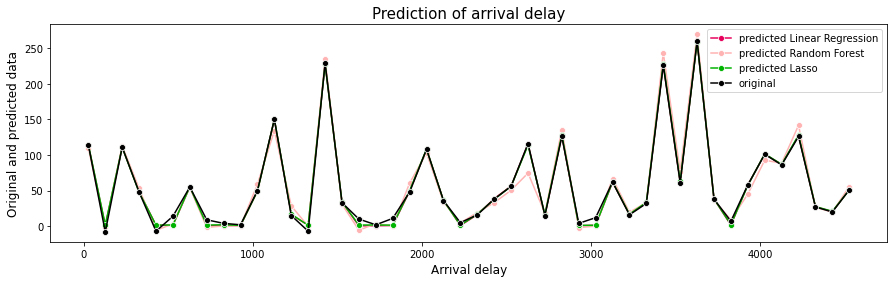

In [163]:
#compare values from test and predict
#for simple visualization let's take sistematic sample
step_num = 100
def randomNum():
    num = np.random.randint(1, 50)
    return num
num = randomNum()

simple_df1 = a[num:len(a):step_num]
simple_df2 = b[num:len(b):step_num]
simple_df3 = c[num:len(c):step_num]
simple_df4 = d[num:len(d):step_num]

plt.figure(figsize =(15, 4))
sns.lineplot(data=simple_df2, color='#e6005c',label='predicted Linear Regression', marker='o')
sns.lineplot(data=simple_df3, color='#ffb3b3',label='predicted Random Forest', marker='o')
sns.lineplot(data=simple_df4, color='#00b300',label='predicted Lasso', marker='o')
sns.lineplot(data=simple_df1, color='#000000',label='original', marker='o')
plt.title("Prediction of arrival delay",fontsize=15)
plt.xlabel("Arrival delay",fontsize=12)
plt.ylabel("Original and predicted data",fontsize=12)

plt.show()

## Level 2

### Exercise 5

##### Feature-engineering process to get better prediction.

Feature engineering:
- In the first part of the notebook are used processes like: dealing with NaN values, extracted columns, removing values
- Other processes to explore: Reducing the skewness, Scaling, Dummies variables

#### Scaling - standardization

In [175]:
#random sample
df_flights_sample2 = df_flights.sample(n = 1000)
df_flights_sample2.head(5)

,ArrDelay,DepDelay,Distance,CarrierDelay,WeatherDelay,NASDelay,SecurityDelay,LateAircraftDelay,Month,DayofMonth
1061763,58.0,53.0,1576,0.0,0.0,5.0,0.0,53.0,6,9
1516344,45.0,21.0,944,2.0,0.0,24.0,0.0,19.0,9,25
1407792,133.0,131.0,1626,40.0,0.0,2.0,0.0,91.0,8,7
168926,2.0,9.0,1069,0.0,0.0,0.0,0.0,0.0,1,3
866461,21.0,31.0,944,12.0,0.0,0.0,0.0,9.0,5,1


In [188]:
#StandardScaler
from sklearn.preprocessing import StandardScaler
from numpy import asarray
scaler = StandardScaler()
data = asarray(df_flights_sample2)

#Fit the data - scaling
df_flights_sample2_std = pd.DataFrame(scaler.fit_transform(data),columns=df_flights_sample2.columns)
df_flights_sample2_std.head(5)

,ArrDelay,DepDelay,Distance,CarrierDelay,WeatherDelay,NASDelay,SecurityDelay,LateAircraftDelay,Month,DayofMonth
0,0.041044,-0.041919,0.605267,-0.317411,-0.06891,-0.420162,-0.045066,0.886102,-0.081326,-0.720480
1,-0.151720,-0.548490,-0.203503,-0.244030,-0.06891,-0.037629,-0.045066,-0.020260,0.812368,1.066481
2,1.153145,1.192849,0.669252,1.150217,-0.06891,-0.480562,-0.045066,1.899094,0.514470,-0.943851
3,-0.789325,-0.738454,-0.043541,-0.317411,-0.06891,-0.520828,-0.045066,-0.526756,-1.570816,-1.390591
4,-0.507593,-0.390187,-0.203503,0.122877,-0.06891,-0.520828,-0.045066,-0.286837,-0.379224,-1.613961


In [202]:
X = df_flights_sample2_std.drop('ArrDelay',axis=1)
y = df_flights_sample2_std['ArrDelay']
#Train 70%, test 30%, test_size is the percentage and random_state is for initilizing random number generator
X_trainStd, X_testStd, y_trainStd, y_testStd = train_test_split(X, y, test_size=0.3, random_state=42)

In [203]:
#linear regression
model1_std = LinearRegression(fit_intercept = False, normalize=True, positive=True)
model1_std.fit(X_trainStd,y_trainStd)
test_predictions1_std = model1_std.predict(X_testStd)

In [207]:
#random forest
model2_std = RandomForestRegressor(n_estimators = 100, max_depth=30, random_state = 42)
model2_std.fit(X_trainStd,y_trainStd)
test_predictions2_std = model2_std.predict(X_testStd)

In [204]:
#lasso
model3_std = LassoCV(n_alphas = 100, fit_intercept=True, max_iter=100,random_state = 42)
model3_std.fit(X_trainStd,y_trainStd)
test_predictions3_std = model3_std.predict(X_testStd)

In [216]:
score1 = model1.score(X_train,y_train)
score1_std = model1_std.score(X_trainStd,y_trainStd)
print(score1, score1_std)

0.9968310008989788 0.9923194375877311


In [217]:
score2 = model2.score(X_train,y_train)
score2_std = model2_std.score(X_trainStd,y_trainStd)
print(score2, score2_std)

0.9900455722501987 0.9903052393920989


In [218]:
score3 = model3.score(X_train,y_train)
score3_std = model3_std.score(X_trainStd,y_trainStd)
print(score3, score3_std)

0.9583348320165543 0.9924382175719516


Interpretation: 
- Model with Lasso Regression improved significatly with standardization of values.
- Linear Regression and Random Forest Regression has very similar results.

#### PCA

In [265]:
#PCA Projection from 30 to 2D
from sklearn.decomposition import PCA
pca_values = df_flights_sample2_std.drop('ArrDelay',axis=1)
pca = PCA(n_components=2)
principalComponents = pca.fit_transform(pca_values)
principalDf = pd.DataFrame(data = principalComponents, columns = ['principal component 1', 'principal component 2'])

In [266]:
X = principalDf
y = df_flights_sample2_std['ArrDelay']
#Train 70%, test 30%, test_size is the percentage and random_state is for initilizing random number generator
X_trainPca, X_testPca, y_trainPca, y_testPca = train_test_split(X, y, test_size=0.3, random_state=42)

In [267]:
#linear regression
model1_pca = LinearRegression(fit_intercept = False, normalize=True, positive=True)
model1_pca.fit(X_trainPca,y_trainPca)
test_predictions1_pca = model1_pca.predict(X_testPca)

In [268]:
#random forest
model2_pca = RandomForestRegressor(n_estimators = 100, max_depth=30, random_state = 42)
model2_pca.fit(X_trainPca,y_trainPca)
test_predictions2_pca = model2_pca.predict(X_testPca)

In [269]:
#lasso
model3_pca = LassoCV(n_alphas = 100, fit_intercept=True, max_iter=100,random_state = 42)
model3_pca.fit(X_trainPca,y_trainPca)
test_predictions3_pca = model3_pca.predict(X_testPca)

In [270]:
score1 = model1.score(X_train,y_train)
score1_pca = model1_pca.score(X_trainPca,y_trainPca)
print(score1, score1_pca)

0.9968310008989788 0.9411477926908232


In [271]:
score2 = model2.score(X_train,y_train)
score2_pca = model2_pca.score(X_trainPca,y_trainPca)
print(score2, score2_pca)

0.9900455722501987 0.9907788189541927


In [272]:
score3 = model3.score(X_train,y_train)
score3_pca = model3_pca.score(X_trainPca,y_trainPca)
print(score3, score3_pca)

0.9583348320165543 0.945177623238178


Interpretation:
- This method is making the models less accurate by simplifying the values in two components
- Interesting thing is that this transformation is not effecting the Random Forest Regression model.

#### Scaling - normalization

In [219]:
#Normalize
from sklearn import preprocessing
data = asarray(df_flights_sample2)

#Fit the data - scaling
df_flights_sample2_nor = pd.DataFrame(preprocessing.normalize(data),columns=df_flights_sample2.columns)
df_flights_sample2_nor.head(5)

,ArrDelay,DepDelay,Distance,CarrierDelay,WeatherDelay,NASDelay,SecurityDelay,LateAircraftDelay,Month,DayofMonth
0,0.036735,0.033568,0.998168,0.000000,0.0,0.003167,0.0,0.033568,0.003800,0.005700
1,0.047560,0.022195,0.997700,0.002114,0.0,0.025365,0.0,0.020081,0.009512,0.026422
2,0.081111,0.079891,0.991625,0.024394,0.0,0.001220,0.0,0.055497,0.004879,0.004269
3,0.001871,0.008419,0.999958,0.000000,0.0,0.000000,0.0,0.000000,0.000935,0.002806
4,0.022225,0.032809,0.999074,0.012700,0.0,0.000000,0.0,0.009525,0.005292,0.001058


In [221]:
X = df_flights_sample2_nor.drop('ArrDelay',axis=1)
y = df_flights_sample2_nor['ArrDelay']
#Train 70%, test 30%, test_size is the percentage and random_state is for initilizing random number generator
X_trainNor, X_testNor, y_trainNor, y_testNor = train_test_split(X, y, test_size=0.3, random_state=42)

In [298]:
#linear regression
model1_nor = LinearRegression(fit_intercept = False, normalize=True, positive=True)
model1_nor.fit(X_trainNor,y_trainNor)
test_predictions1_nor = model1_nor.predict(X_testNor)

In [223]:
#random forest
model2_nor = RandomForestRegressor(n_estimators = 100, max_depth=30, random_state = 42)
model2_nor.fit(X_trainNor,y_trainNor)
test_predictions2_nor = model2_nor.predict(X_testNor)

In [224]:
#lasso
model3_nor = LassoCV(n_alphas = 100, fit_intercept=True, max_iter=100,random_state = 42)
model3_nor.fit(X_trainNor,y_trainNor)
test_predictions3_nor = model3_nor.predict(X_testNor)

In [299]:
score1 = model1.score(X_train,y_train)
score1_nor = model1_nor.score(X_trainNor,y_trainNor)
print(score1, score1_nor)

0.9968310008989788 0.9942694953972696


In [226]:
score2 = model2.score(X_train,y_train)
score2_nor = model2_nor.score(X_trainNor,y_trainNor)
print(score2, score2_nor)

0.9900455722501987 0.9979912083353898


In [227]:
score3 = model3.score(X_train,y_train)
score3_nor = model3_nor.score(X_trainNor,y_trainNor)
print(score3, score3_nor)

0.9583348320165543 0.9934210322746609


Interpretation: 
- All models improved significatly with normalization of values.
- Normalization might be the best approach beacuse the values in the original dataset are not normally distributed

## Level 3

### Exercise 6

##### Prediction without departure delay variable.

In [288]:
#choose columns with no obvious relationship with delay
b.columns

Index(['Unnamed: 0', 'Year', 'Month', 'DayofMonth', 'DayOfWeek', 'DepTime',
       'CRSDepTime', 'ArrTime', 'CRSArrTime', 'UniqueCarrier', 'FlightNum',
       'TailNum', 'ActualElapsedTime', 'CRSElapsedTime', 'AirTime', 'ArrDelay',
       'DepDelay', 'Origin', 'Dest', 'Distance', 'TaxiIn', 'TaxiOut',
       'Cancelled', 'CancellationCode', 'Diverted', 'CarrierDelay',
       'WeatherDelay', 'NASDelay', 'SecurityDelay', 'LateAircraftDelay'],
      dtype='object')

In [289]:
df_flights2 = b[['Cancelled','ArrDelay','Distance','Month', 'DayofMonth','DayOfWeek','TaxiIn','TaxiOut']]
df_flights2.head(3)

,Cancelled,ArrDelay,Distance,Month,DayofMonth,DayOfWeek,TaxiIn,TaxiOut
168228,0,-19.0,1522,1,1,2,10.0,18.0
168229,0,-6.0,766,1,1,2,5.0,11.0
168230,0,19.0,766,1,1,2,15.0,18.0


In [290]:
#deleting rows with cancelled flights
df_flights2 = df_flights2.loc[df_flights2['Cancelled'] == 0]
df_flights2.drop('Cancelled',axis=1, inplace=True)
df_flights2.reset_index()
df_flights2.tail(3)

,ArrDelay,Distance,Month,DayofMonth,DayOfWeek,TaxiIn,TaxiOut
1921774,199.0,1005,12,31,3,11.0,19.0
1921775,71.0,1005,12,31,3,8.0,12.0
1921776,31.0,1005,12,31,3,5.0,16.0


In [292]:
#Do I have complete values dataset? how many NaN values I have?
a = df_flights2['ArrDelay'].isnull().sum()
b = df_flights2['Distance'].isnull().sum()
c = df_flights2['Month'].isnull().sum()
d = df_flights2['DayofMonth'].isnull().sum()
e = df_flights2['DayOfWeek'].isnull().sum()
f = df_flights2['TaxiIn'].isnull().sum()
g = df_flights2['TaxiOut'].isnull().sum()
print(a, b, c, d, e, f, g)

121 0 0 0 0 112 0


In [294]:
#Replace NaN values with 0 and check new df
df_flights2['ArrDelay'] = df_flights2['ArrDelay'].replace(np.nan, 0)
df_flights2['TaxiIn'] = df_flights2['TaxiIn'].replace(np.nan, 0)
df_flights2.isnull().values.any()

False

In [295]:
#random sample
df_flights_sample3 = df_flights2.sample(n = 1000)
df_flights_sample3.head(5)

,ArrDelay,Distance,Month,DayofMonth,DayOfWeek,TaxiIn,TaxiOut
1245197,77.0,2586,7,13,7,40.0,32.0
711864,57.0,1626,4,10,4,13.0,14.0
1617966,-7.0,1069,10,27,1,5.0,15.0
1617164,15.0,944,10,17,5,4.0,14.0
170773,107.0,740,1,17,4,7.0,21.0


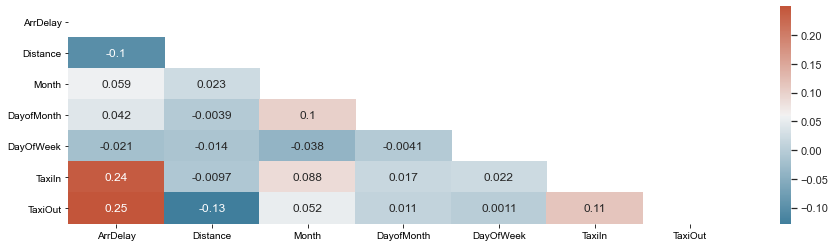

In [296]:
#Correlation matrix
fig,ax = plt.subplots(figsize=(15,4))
corr = df_flights_sample3.corr()
sns.set_theme(style="white")
cmap = sns.diverging_palette(230, 20, as_cmap=True)

matrix = np.triu(corr)
sns.heatmap(corr, annot=True, mask=matrix, cmap=cmap)
plt.show()

In [300]:
X = df_flights_sample3.drop('ArrDelay',axis=1)
y = df_flights_sample3['ArrDelay']
#Train 70%, test 30%, test_size is the percentage and random_state is for initilizing random number generator
X_train2, X_test2, y_train2, y_test2 = train_test_split(X, y, test_size=0.3, random_state=42)

In [310]:
#linear regression
model1_2 = LinearRegression(fit_intercept = False, normalize=True, positive=True)
model1_2.fit(X_train2,y_train2)
test_predictions1_2 = model1_2.predict(X_test2)

In [311]:
#random forest
model2_2 = RandomForestRegressor(n_estimators = 100, max_depth=30, random_state = 42)
model2_2.fit(X_train2,y_train2)
test_predictions2_2 = model2_2.predict(X_test2)

In [312]:
#lasso
model3_2 = LassoCV(n_alphas = 100, fit_intercept=True, max_iter=100,random_state = 42)
model3_2.fit(X_train2,y_train2)
test_predictions3_2 = model3_2.predict(X_test2)

In [317]:
#original values
MAE1 = mean_absolute_error(y_test, test_predictions1)
MSE1 = mean_squared_error(y_test, test_predictions1)
RMSE1 = np.sqrt(MSE1)

MAE2 = mean_absolute_error(y_test, test_predictions2)
MSE2 = mean_squared_error(y_test, test_predictions2)
RMSE2 = np.sqrt(MSE2)

MAE3 = mean_absolute_error(y_test, test_predictions3)
MSE3 = mean_squared_error(y_test, test_predictions3)
RMSE3 = np.sqrt(MSE3)

In [318]:
#new values
MAE1_2 = mean_absolute_error(y_test2, test_predictions1_2)
MSE1_2 = mean_squared_error(y_test2, test_predictions1_2)
RMSE1_2 = np.sqrt(MSE1_2)

MAE2_2 = mean_absolute_error(y_test2, test_predictions2_2)
MSE2_2 = mean_squared_error(y_test2, test_predictions2_2)
RMSE2_2 = np.sqrt(MSE2_2)

MAE3_2 = mean_absolute_error(y_test2, test_predictions3_2)
MSE3_2 = mean_squared_error(y_test2, test_predictions3_2)
RMSE3_2 = np.sqrt(MSE2_2)

In [322]:
df_summary = pd.DataFrame({'First MAE':[MAE1,MAE2,MAE3], 'Second MAE':[MAE1_2,MAE2_2,MAE3_2],
                           'First MSE':[MSE1,MSE2,MSE3], 'Second MSE':[MSE1_2,MSE2_2,MSE3_2],
                           'First RMSE':[RMSE1,RMSE2,RMSE3], 'Second RMSE':[RMSE1_2,RMSE2_2,RMSE3_2]})
df_summary

,First MAE,Second MAE,First MSE,Second MSE,First RMSE,Second RMSE
0,2.260870,44.194967,19.294670,4334.974576,4.392570,65.840524
1,9.420243,48.371100,300.474137,4811.343808,17.334190,69.363851
2,11.967662,44.407854,323.724450,4259.408096,17.992344,69.363851


Interpretation:
- The good results from the first test are conditioned by values directly related to Arrival Delay, because in the second test the results are much more worse.
- If we eliminate the values correlated to arrival delay we can get more real life scenario.
- With the second model we could work further on applying some feature engineering methods to improve the accuracy.

#### Notes
* Linear regression
    - https://realpython.com/linear-regression-in-python/
* How to visualize regression
    - https://seaborn.pydata.org/tutorial/regression.html
* Advanced linear regression with Statsmodels
    - https://towardsdatascience.com/simple-and-multiple-linear-regression-in-python-c928425168f9
* How to evaluate the model
    - https://towardsdatascience.com/what-are-the-best-metrics-to-evaluate-your-regression-model-418ca481755b
* Decision tree regression
    - https://medium.com/pursuitnotes/decision-tree-regression-in-6-steps-with-python-1a1c5aa2ee16
    - https://towardsdatascience.com/machine-learning-basics-decision-tree-regression-1d73ea003fda
* Random forest
    - https://towardsdatascience.com/random-forest-in-python-24d0893d51c0
* Neural networks classification or regression model
    - https://www.pluralsight.com/guides/machine-learning-neural-networks-scikit-learn
    - https://scikit-learn.org/stable/modules/generated/sklearn.neural_network.MLPRegressor.html
    - https://bit.ly/2ZCHG8S
* More regression algorithms
    - https://medium.com/analytics-vidhya/5-regression-algorithms-you-need-to-know-theory-implementation-37993382122d
* Freezing code
    - https://docs.python-guide.org/shipping/freezing/